<a href="https://colab.research.google.com/github/AditiSatsangi/Miscellaneous-Projects/blob/main/Transefer_learning_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Transfer learning

## Import

In [3]:
import tensorflow as tf
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [4]:
import logging
logger= tf.get_logger()
logger.setLevel(logging.ERROR)


## Download classifier

Download the MobileNet model and create a Keras model from it. MobileNet is expecting images of 224  ×  224 pixels, in 3 color channels (RGB).

In [5]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224
model= tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape= (IMAGE_RES,IMAGE_RES,3))
])

## Run on Single img

61306/61306 [==============================] - 0s 0us/step


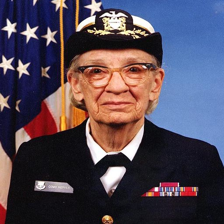

In [6]:
import numpy as np
import PIL.Image as Image
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper


In [7]:
grace_hopper= np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [8]:

result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 9s 9s/step


(1, 1001)

In [9]:
predicted_class= np.argmax(result[0], axis=-1)
predicted_class

653

## Decode Predictions

10484/10484 [==============================] - 0s 0us/step


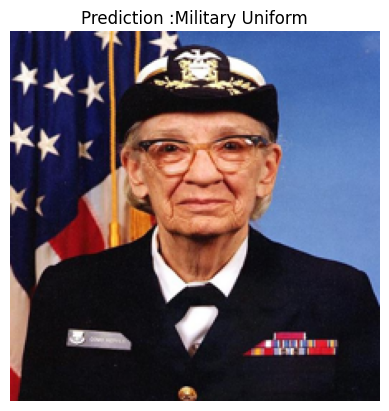

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name= imagenet_labels[predicted_class]
_ = plt.title("Prediction :" + predicted_class_name.title())


# Using Tensorflowc hub model for Cat vs dogs

## Dataset

In [11]:
(train_examples, validation_examples), info= tfds.load(
    'cats_vs_dogs',
    with_info= True,
    as_supervised =True,
    split= ['train[:80%]', 'train[80%:]'],
)
num_examples= info.splits['train'].num_examples
num_classes= info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteQZOAXQ/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [12]:
for i, example_image in enumerate(train_examples.take(3)):
   print("Image {}  shape:{} ".format(i+1, example_image[0].shape))

Image 1  shape:(262, 350, 3) 
Image 2  shape:(409, 336, 3) 
Image 3  shape:(493, 500, 3) 


In [13]:
def format_image(image, label):
  image= tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE= 32
train_batches= train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)


## Run classifer on batch of images

In [14]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 1s 753ms/step


array(['Persian cat', 'malinois', 'tabby', 'Rhodesian ridgeback',
       'shopping cart', 'Egyptian cat', 'tabby',
       'American Staffordshire terrier', 'Egyptian cat', 'tabby',
       'Siamese cat', 'Siamese cat', 'Egyptian cat', 'Leonberg',
       'Persian cat', 'Siamese cat', 'Siamese cat', 'Persian cat',
       'German shepherd', 'Saluki', 'Eskimo dog', 'beagle',
       'Labrador retriever', 'toy terrier', 'collie', 'toy terrier',
       'tiger cat', 'Egyptian cat', 'Rottweiler', 'Saint Bernard',
       'American Staffordshire terrier', 'Chihuahua'], dtype='<U30')

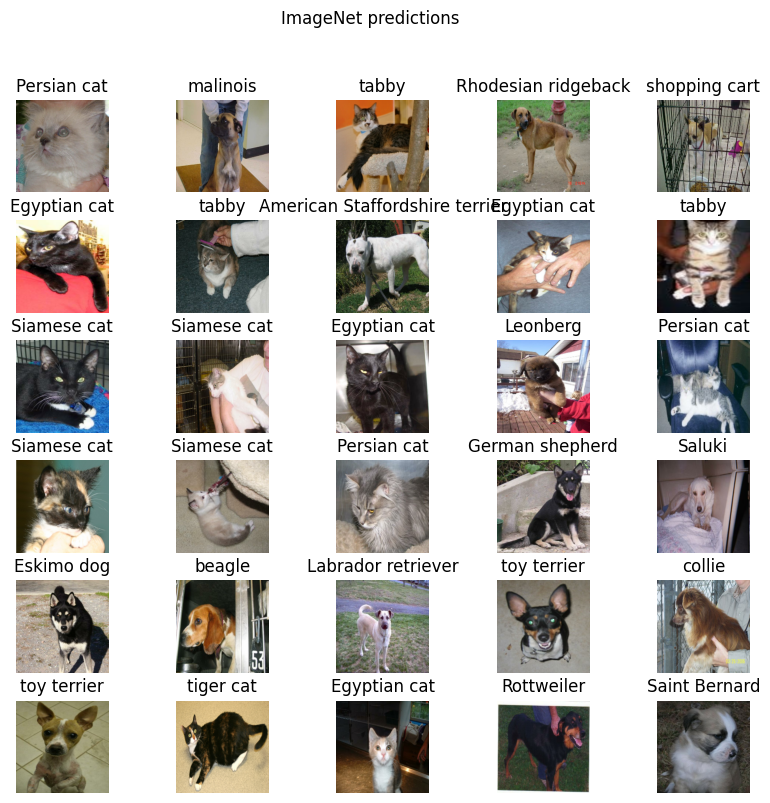

In [15]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## Transfer learning with Tensorflow Hub

In [16]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [17]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [18]:
feature_extractor.trainable = False

## Attach classification head

In [19]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train model

In [20]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 51s 72ms/step - loss: 0.0592 - accuracy: 0.9790 - val_loss: 0.0342 - val_accuracy: 0.9875
Epoch 2/6
582/582 [==============================] - 43s 64ms/step - loss: 0.0301 - accuracy: 0.9902 - val_loss: 0.0434 - val_accuracy: 0.9854
Epoch 3/6
582/582 [==============================] - 42s 62ms/step - loss: 0.0252 - accuracy: 0.9909 - val_loss: 0.0314 - val_accuracy: 0.9895
Epoch 4/6
582/582 [==============================] - 44s 67ms/step - loss: 0.0218 - accuracy: 0.9929 - val_loss: 0.0308 - val_accuracy: 0.9890
Epoch 5/6
582/582 [==============================] - 44s 67ms/step - loss: 0.0198 - accuracy: 0.9934 - val_loss: 0.0316 - val_accuracy: 0.9903
Epoch 6/6
582/582 [==============================] - 42s 64ms/step - loss: 0.0176 - accuracy: 0.9947 - val_loss: 0.0351 - val_accuracy: 0.9895


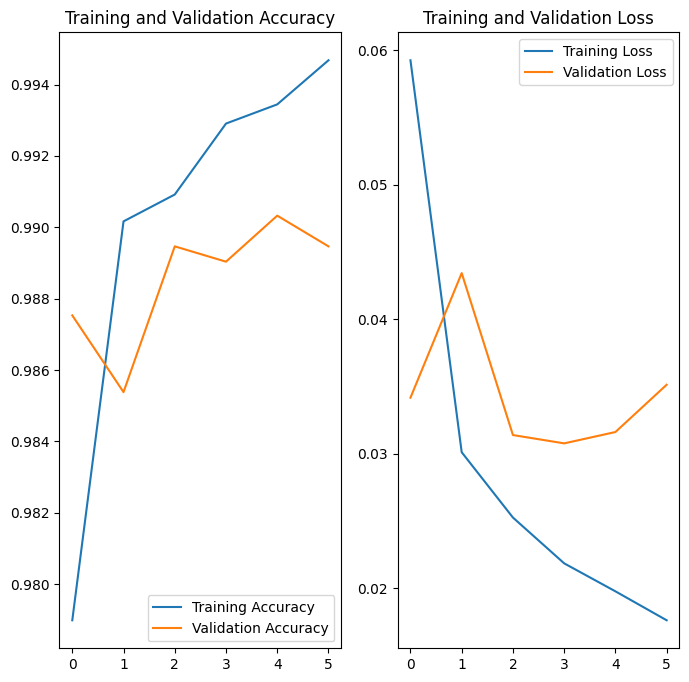

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Check prediction

In [22]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [23]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 1s 518ms/step


array(['cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat',
       'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat',
       'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat',
       'cat', 'dog', 'dog', 'dog', 'dog'], dtype='<U3')

In [24]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1]
Predicted labels:  [0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1]


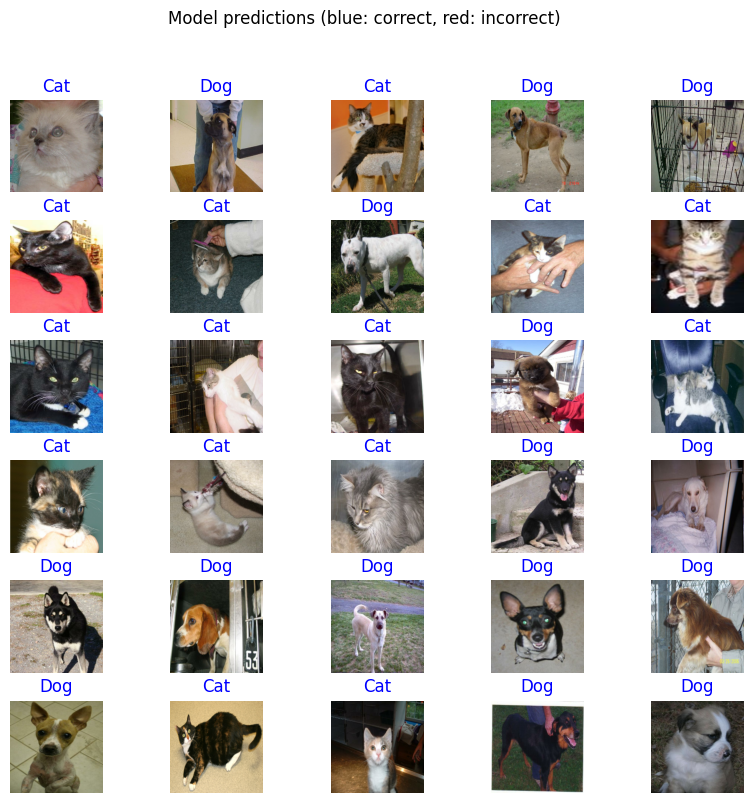

In [25]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")